In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
# Explaination
# the meaning of each variable: paper survey
"""
Gas turbine (GT1) 
Generator Watts Max Selected {Avg}
Exhaust Temp Median Corrected By Average {Avg} 
Compressor Inlet Temperature {Avg}
IGV angle in deg {Avg} 
Compressor Discharge Press Max Select {Avg} 
Compressor Discharge Temperature {Avg} 
"""
def start():
    return None

In [8]:
# read dataset from the file
filename = 'interview data.xlsx'
df = pd.read_excel(filename)
# Drop TimeStamp
df = df.drop(['TimeStamp'], axis=1)
# Five independent Variables
med_exh_tem = df['GT1 Exhaust Temp Median Corrected By Average {Avg}']
IGV_ang = df['GT1 IGV angle in deg {Avg}']
com_disch_pre_max = df['GT1 Compressor Discharge Press Max Select {Avg}']
com_inlet_tem = df['GT1 Compressor Inlet Temperature {Avg}']
com_disch_tem = df['GT1 Compressor Discharge Temperature {Avg}']
# one dependent Variable
gen_max_wat = df['GT1 Generator Watts Max Selected {Avg}']

In [11]:
# Get the pearson correlation between each other
pearsoncorr = df.corr(method='pearson')
pd.set_option('display.max_columns', 6)
print(pearsoncorr)

                                                    GT1 Generator Watts Max Selected {Avg}  \
GT1 Generator Watts Max Selected {Avg}                                            1.000000   
GT1 Exhaust Temp Median Corrected By Average {Avg}                                0.934586   
GT1 Compressor Inlet Temperature {Avg}                                            0.082050   
GT1 IGV angle in deg {Avg}                                                        0.993485   
GT1 Compressor Discharge Press Max Select {Avg}                                   0.990793   
GT1 Compressor Discharge Temperature {Avg}                                        0.934736   

                                                    GT1 Exhaust Temp Median Corrected By Average {Avg}  \
GT1 Generator Watts Max Selected {Avg}                                                       0.934586    
GT1 Exhaust Temp Median Corrected By Average {Avg}                                           1.000000    
GT1 Compressor Inlet Te

[['GT1 Generator Watts Max Selected {Avg}'], ['GT1 Exhaust Temp Median Corrected By Average {Avg}'], ['GT1 Compressor Inlet Temperature {Avg}'], ['GT1 IGV angle in deg {Avg}'], ['GT1 Compressor Discharge Press Max Select {Avg}'], ['GT1 Compressor Discharge Temperature {Avg}']]


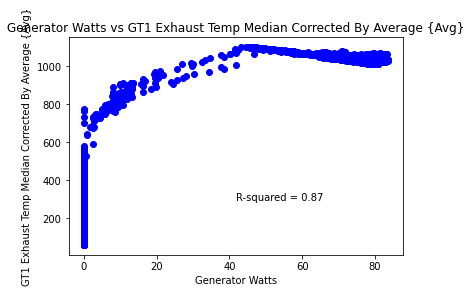

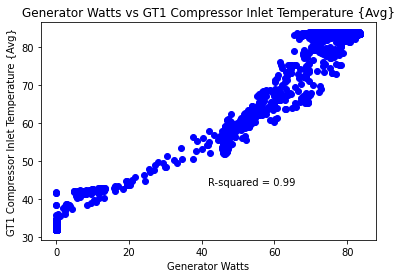

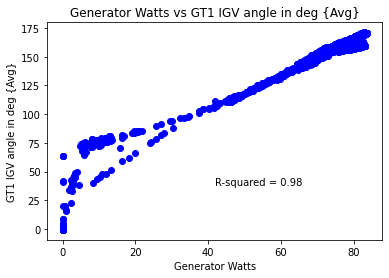

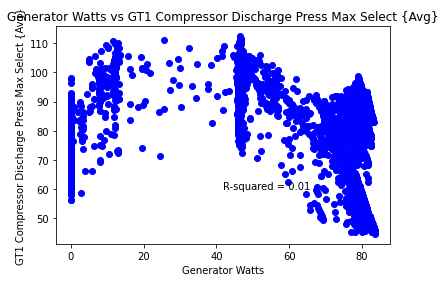

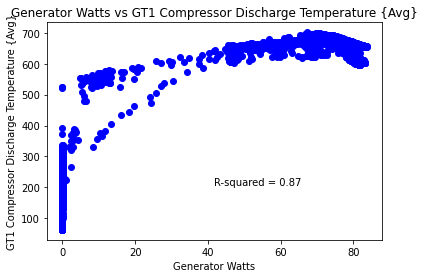

In [16]:
# calculate R square
# Create bars and choose color
vars = [med_exh_tem, IGV_ang, com_disch_pre_max, com_inlet_tem, com_disch_tem]
name = []
for col in df.columns:
    name.append([col])
len_var = len(vars)
for i in range(len_var):
    plt.plot(gen_max_wat, vars[i], 'o', color='blue')
    # Add title and axis names
    plt.title('Generator Watts vs {}'.format(name[i+1][0]))
    plt.ylabel('{}'.format(name[i+1][0]))
    plt.xlabel('Generator Watts')
    corr_matrix = np.corrcoef(gen_max_wat, vars[i])
    corr = corr_matrix[0,1]
    R_sq = corr**2
    plt.text(0.5, 0.25, 'R-squared = %0.2f' % R_sq, transform=plt.gca().transAxes)
    plt.show()

In [38]:
# From abobe analysis:
# Higher relationship with generator watts
# 'GT1 Compressor Inlet Temperature {Avg}'
# 'GT1 IGV angle in deg {Avg}'
# Middle relationship with generator watts
# 'GT1 Exhaust Temp Median Corrected By Average {Avg}'
# 'GT1 Compressor Discharge Temperature {Avg}'
# Lower relationship with generator watts
# 'GT1 Compressor Discharge Press Max Select {Avg}'

# TOB method:
# Data Normalization: Normalize the data in the array so each variable spans a range from minus 1 to plus 1 (−1,+1).
vars = [med_exh_tem, IGV_ang, com_disch_pre_max, com_inlet_tem, com_disch_tem, gen_max_wat]

# reform data
new_list = []
for i in range(len(vars[0])):
    new_list.append([vars[0][i], vars[1][i], vars[2][i], vars[3][i], vars[4][i], vars[5][i]])
    
vars1 = np.array(new_list)
data = vars1
scaler = MinMaxScaler(feature_range = (-1, 1))
vars1 = scaler.fit_transform(data)

data = gen_max_wat.values
data = data.reshape(-1, 1)
scaler1 = MinMaxScaler(feature_range = (-1, 1))
y_pre = scaler1.fit_transform(data)

In [18]:
# training, tuning and testing subsets.
# 20% test (last 20% data for test). Because they are newer data. Remaining: 60% train, 20% validation
new_list = list(vars1)
test_data = new_list[round(len(new_list) * 0.8):]
train_all = new_list[0:round(len(new_list) * 0.8)]
train, dev = train_test_split(train_all, test_size=0.2, random_state=42)

In [20]:
# TOB Methodology and Mathematical Formulation
# calculate VSE(variable squared error) between each variable in the J data records of the tuning-data 
# subset and the K data records in the training-data
Xj_pre = []
Xj_act = []
Q_all = [2,3,4,5,6,7,8,9]
for Q in Q_all:
    for j in range(len(dev)):
        sum_VSEn = []
        for i in range(len(train)):
            VSEn = 0
            for n in range(len(dev[0])):
                if n == 0:
                    Wn = 0.1
                elif n == 1:
                    Wn = 0.9
                elif n == 2:
                    Wn = 0.8
                elif n == 3:
                    Wn = 0.02
                elif n == 4:
                    Wn = 0.15
                else:
                    Wn = 0
                VSEn += (train[i][n] - dev[j][n])**2 * Wn
            sum_VSEn.append((VSEn,i))
        sor_sum_vse = sorted(sum_VSEn)
        # Select and rank (lowest in ∑VSE is ranked number 1) the top-10-matching data records in the 
        # training subset for each tuning subset data record.
        sel_Q = []
        for i in range(Q):
            sel_Q.append(train[sor_sum_vse[i][1]])
        # That fraction is proportional to the relative ∑VSE scores of those Q records for the jth data record
        VSEq_sum = []
        for i in range(Q):
            VSEq = 0
            for n in range(len(dev[0])):
                if n == 0:
                    Wn = 0.1
                elif n == 1:
                    Wn = 0.9
                elif n == 2:
                    Wn = 0.8
                elif n == 3:
                    Wn = 0.02
                elif n == 4:
                    Wn = 0.15
                else:
                    Wn = 0
                VSEq += (sel_Q[i][n] - dev[j][n])**2*Wn
            VSEq_sum.append(VSEq)
        sum_VSEq = sum(VSEq_sum)
        fq = []
        for i in range(Q):
            fq.append(VSEq_sum[i]/sum_VSEq)
        Xj_tem = 0
        for i in range(Q):
            Xj_tem += sel_Q[i][-1]*(1-fq[i])
        Xj_pre.append(Xj_tem)
        Xj_act.append(dev[j][-1])

    R = r2_score(Xj_pre, Xj_act)
    MSE = mean_squared_error(Xj_pre, Xj_act)
    RMSE = mean_squared_error(Xj_pre, Xj_act, squared=False)

    print('Q = %.2f' %(testScore), R,MSE,RMSE)


0.9999660872265789 2.6079664526303358e-05 0.005106825288406032
0.7908387739857942 0.40418039162436936 0.6357518317900227
0.6274008463183156 1.3467158883897283 1.16048088669729
0.5137353889641804 2.827822721859648 1.6816131308537192
0.43208069337243904 4.8471596059408535 2.201626581857344
0.3710429808089626 7.4049192440259635 2.7211981265659366
0.32385004976584075 10.500381589071992 3.2404292291411014
0.2863177092019251 14.134962320064066 3.7596492283275667


In [21]:
# From above results, the optimal Q = 2. ((i.e. Q = 2 to 9))
# Varying the values applied to the N input-variable weights (Wn). 
# Find: w1 = 0.3, w2 = 0.8, w3 = 0.8, w4 = 0.02, w5 = 0.3, w6 = 0
# Test the model with the test dataset
Xj_pre1 = []
Xj_act1 = []
Q = 2
for j in range(len(dev)):
    sum_VSEn = []
    for i in range(len(test_data)):
        VSEn = 0
        for n in range(len(dev[0])):
            if n == 0:
                Wn = 0.1
            elif n == 1:
                Wn = 0.9
            elif n == 2:
                Wn = 0.8
            elif n == 3:
                Wn = 0.02
            elif n == 4:
                Wn = 0.15
            else:
                Wn = 0
            VSEn += (test_data[i][n] - dev[j][n])**2 * Wn
        sum_VSEn.append((VSEn,i))
    sor_sum_vse = sorted(sum_VSEn)
    # Select and rank (lowest in ∑VSE is ranked number 1) the top-10-matching data records in the training 
    # subset for each tuning subset data record.
    sel_Q = []
    for i in range(Q):
        sel_Q.append(test_data[sor_sum_vse[i][1]])
    # That fraction is proportional to the relative ∑VSE scores of those Q records for the jth data record
    VSEq_sum = []
    for i in range(Q):
        VSEq = 0
        for n in range(len(dev[0])):
            if n == 0:
                Wn = 0.1
            elif n == 1:
                Wn = 0.9
            elif n == 2:
                Wn = 0.8
            elif n == 3:
                Wn = 0.02
            elif n == 4:
                Wn = 0.15
            else:
                Wn = 0
            VSEq += (sel_Q[i][n] - dev[j][n])**2*Wn
        VSEq_sum.append(VSEq)
    sum_VSEq = sum(VSEq_sum)
    fq = []
    for i in range(Q):
        fq.append(VSEq_sum[i]/sum_VSEq)
    Xj_tem = 0
    for i in range(Q):
        Xj_tem += sel_Q[i][-1]*(1-fq[i])
    Xj_pre1.append(Xj_tem)
    Xj_act1.append(dev[j][-1])

R1 = r2_score(Xj_pre1, Xj_act1)
MSE1 = mean_squared_error(Xj_pre1, Xj_act1)
RMSE1 = mean_squared_error(Xj_pre1, Xj_act1, squared=False)

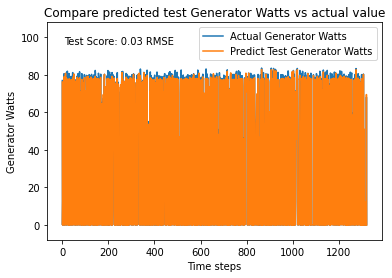

In [22]:
# plot the results with compare predict train vs actual

# plt.plot(scaler1.inverse_transform(Xj_act),label = 'Actual Generator Watts')
# plt.plot(scaler1.inverse_transform(Xj_pre), label = 'Predict Train Generator Watts')
# plt.title('Compare predicted train Generator Watts vs actual value')
# plt.text(0.05, 0.95, 'Train Score: %.2f RMSE' % (RMSE), transform=plt.gca().transAxes)
# plt.xlabel('Time steps')
# plt.ylabel('Generator Watts')
# plt.legend(loc = 1)
# #plt.ylim([-8, 108])
# plt.show()
Xj_act1 = np.array(Xj_act1)
Xj_pre1 = np.array(Xj_pre1)
Xj_act1 = Xj_act1.reshape(-1, 1)
Xj_pre1 = Xj_pre1.reshape(-1, 1)
plt.plot(scaler1.inverse_transform(Xj_act1), label = 'Actual Generator Watts')
plt.plot(scaler1.inverse_transform(Xj_pre1), label = 'Predict Test Generator Watts')
plt.title('Compare predicted test Generator Watts vs actual value')
plt.text(0.05, 0.90, 'Test Score: %.2f RMSE' % (RMSE1), transform=plt.gca().transAxes)
plt.xlabel('Time steps')
plt.ylabel('Generator Watts')
plt.legend(loc = 1)
plt.ylim([-8, 108])
plt.show()

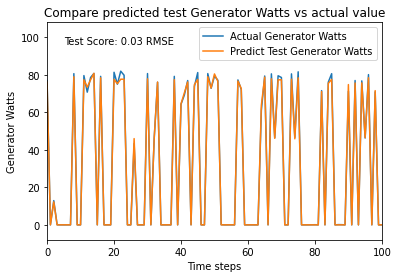

In [23]:
# Parts of the results
Xj_act1 = np.array(Xj_act1)
Xj_pre1 = np.array(Xj_pre1)
Xj_act1 = Xj_act1.reshape(-1, 1)
Xj_pre1 = Xj_pre1.reshape(-1, 1)
plt.plot(scaler1.inverse_transform(Xj_act1), label = 'Actual Generator Watts')
plt.plot(scaler1.inverse_transform(Xj_pre1), label = 'Predict Test Generator Watts')
plt.title('Compare predicted test Generator Watts vs actual value')
plt.text(0.05, 0.90, 'Test Score: %.2f RMSE' % (RMSE1), transform=plt.gca().transAxes)
plt.xlabel('Time steps')
plt.ylabel('Generator Watts')
plt.legend(loc = 1)
plt.ylim([-8, 108])
plt.xlim([0, 100])
plt.show()

In [24]:
# As we can see, For random input, TOB model can give very accurate prediction results
def name():
    return 'Shengbin Wang'
# https://www.sciencedirect.com/science/article/pii/S2405656118300695
# https://link.springer.com/content/pdf/10.1007/s42452-020-2249-7.pdf
# https://machinelearningmastery.com/sensitivity-analysis-of-dataset-size-vs-model-performance/

In [30]:
dev = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
class TOB_model():
    def predict(dev):
        dev.append(0)
        dev = np.array(dev)
        input = np.array([input])
        dev = scaler.transform(input)
        Xj_pre1 = []
        Xj_act1 = []
        Q = 2
        for j in range(len(dev)):
            sum_VSEn = []
            for i in range(len(train)):
                VSEn = 0
                for n in range(len(dev[0])):
                    if n == 0:
                        Wn = 0.1
                    elif n == 1:
                        Wn = 0.9
                    elif n == 2:
                        Wn = 0.8
                    elif n == 3:
                        Wn = 0.02
                    elif n == 4:
                        Wn = 0.15
                    else:
                        Wn = 0
                    VSEn += (train[i][n] - dev[j][n])**2 * Wn
                sum_VSEn.append((VSEn,i))
            sor_sum_vse = sorted(sum_VSEn)
            # Select and rank (lowest in ∑VSE is ranked number 1) the top-10-matching data records in the training 
            # subset for each tuning subset data record.
            sel_Q = []
            for i in range(Q):
                sel_Q.append(train[sor_sum_vse[i][1]])
            # That fraction is proportional to the relative ∑VSE scores of those Q records for the jth data record
            VSEq_sum = []
            for i in range(Q):
                VSEq = 0
                for n in range(len(dev[0])):
                    if n == 0:
                        Wn = 0.1
                    elif n == 1:
                        Wn = 0.9
                    elif n == 2:
                        Wn = 0.8
                    elif n == 3:
                        Wn = 0.02
                    elif n == 4:
                        Wn = 0.15
                    else:
                        Wn = 0
                    VSEq += (sel_Q[i][n] - dev[j][n])**2*Wn
                VSEq_sum.append(VSEq)
            sum_VSEq = sum(VSEq_sum)
            fq = []
            for i in range(Q):
                fq.append(VSEq_sum[i]/sum_VSEq)
            Xj_tem = 0
            for i in range(Q):
                Xj_tem += sel_Q[i][-1]*(1-fq[i])
            Xj_pre1.append(Xj_tem)
            Xj_act1.append(dev[j][-1])
            Xj_pre1 = np.array(Xj_pre1)
            res = scaler1.inverse_transform(Xj_pre1)
        return res

In [31]:
import pickle
pickle.dump(TOB_model, open( "tob_model", "wb" ))

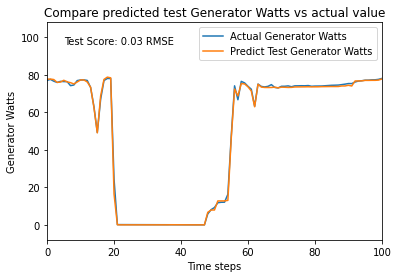

In [33]:
a = [1041.634602,     83.93973463,  161.6997075,    65.03660232,  675.9693427]
a.append(0)
n1 = np.array(a)
in1 = np.array([n1])
m = scaler.transform(in1)

dev = list(m)
Xj_pre1 = []
Xj_act1 = []
Q = 2
for j in range(len(dev)):
    sum_VSEn = []
    for i in range(len(train)):
        VSEn = 0
        for n in range(len(dev[0])):
            if n == 0:
                Wn = 0.1
            elif n == 1:
                Wn = 0.9
            elif n == 2:
                Wn = 0.8
            elif n == 3:
                Wn = 0.02
            elif n == 4:
                Wn = 0.15
            else:
                Wn = 0
            VSEn += (train[i][n] - dev[j][n])**2 * Wn
        sum_VSEn.append((VSEn,i))
    sor_sum_vse = sorted(sum_VSEn)
    # Select and rank (lowest in ∑VSE is ranked number 1) the top-10-matching data records in the training 
    # subset for each tuning subset data record.
    sel_Q = []
    for i in range(Q):
        sel_Q.append(train[sor_sum_vse[i][1]])
    # That fraction is proportional to the relative ∑VSE scores of those Q records for the jth data record
    VSEq_sum = []
    for i in range(Q):
        VSEq = 0
        for n in range(len(dev[0])):
            if n == 0:
                Wn = 0.1
            elif n == 1:
                Wn = 0.9
            elif n == 2:
                Wn = 0.8
            elif n == 3:
                Wn = 0.02
            elif n == 4:
                Wn = 0.15
            else:
                Wn = 0
            VSEq += (sel_Q[i][n] - dev[j][n])**2*Wn
        VSEq_sum.append(VSEq)
    sum_VSEq = sum(VSEq_sum)
    fq = []
    for i in range(Q):
        fq.append(VSEq_sum[i]/sum_VSEq)
    Xj_tem = 0
    for i in range(Q):
        Xj_tem += sel_Q[i][-1]*(1-fq[i])
    Xj_pre1.append(Xj_tem)
    Xj_act1.append(dev[j][-1])
    
Xj_act1 = np.array(Xj_act1)
Xj_pre1 = np.array(Xj_pre1)
Xj_act1 = Xj_act1.reshape(-1, 1)
Xj_pre1 = Xj_pre1.reshape(-1, 1)
plt.plot(scaler1.inverse_transform(Xj_act1), label = 'Actual Generator Watts')
plt.plot(scaler1.inverse_transform(Xj_pre1), label = 'Predict Test Generator Watts')
plt.title('Compare predicted test Generator Watts vs actual value')
plt.text(0.05, 0.90, 'Test Score: %.2f RMSE' % (RMSE1), transform=plt.gca().transAxes)
plt.xlabel('Time steps')
plt.ylabel('Generator Watts')
plt.legend(loc = 1)
plt.ylim([-8, 108])
plt.xlim([0, 100])
plt.show()